
Let's start playing with a Distance based ML model, [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)

This kind of model tries to predict a value by averaging the nearest kneighbors of the value we are looking for. That's why we call them *Distance Based*.

Same remark as the one done with Gradient Descent based model, I should use a scaler to normalize my dataset before fitting the model.

I've choosen to tune two of its parameters:

- The n_neighbors parameter, an int setting the number of kneighbors to search to predict value

- The p parameter to define the *distance* calculation algorythm that could be either p=1 for *manhattan* algorythm, p=2 for *euclidian* one.

Let's start by loading [my_utils](my_utils.ipynb) and other usefull libraries.

In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


# Import libraries


In [2]:
# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Grid Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# KNeighbors regressor Model
from sklearn.neighbors import KNeighborsRegressor

# Load train/valid data
Nothing special here, use the *loadXy()* function to load train/valid X and y datasets.

In [3]:
# Load X and y
X_tr, y_tr, X_va, y_va=load_Xy(frac=FRAC_VALUE_FOR_ML)


# GridSearch

## Define pipeline and grid parameters

Scaler and PCA will be configured in the Pipeline and managed as grid parameters:

### Scaler

- StandardScaler()

- MinMaxScaler()

### PCA

- PCA(0.8)

- PCA(0.9)

- PCA(0.95)

For both PCA ans Scaler, the grid search will be configured to let the search process to disable them (setting *None* as grid parameter)

In [4]:
# Define list of scaler used in grid search
scalers=[StandardScaler(), MinMaxScaler(), None]

# Define list of PCA reduction used in grid search
pcas=[PCA(0.8), PCA(0.9), PCA(0.95), None]

In [5]:
# Initialize KNeighborsRegressor ML model
model = KNeighborsRegressor()

# Define pipeline with scaler, pca and model choosen
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("model", model),
])

# Define base grid search parameters
param_grid = {
    "scaler": scalers,
    "pca": pcas
}



## RandomizedSearchCV with large parameters scope

Start first with a *RandomizedSearchCV* on a very large scope of parameters, setting the number random iterations to 100.


In [6]:
# Set specific model parameters to param_grid
param_grid["model__n_neighbors"]=[*range(1,100,1)]
param_grid["model__p"]=[1,2]

# Number of random search iterations (the more the slower ;-) )
ITERATIONS=100

# Initialize RandomizedSearchCV object. Note that return_train_score=True
random_search = RandomizedSearchCV(pipe,
                                   param_grid,
                                   n_iter=ITERATIONS,
                                   scoring=custom_scorer,
                                   random_state=RANDOM_STATE,
                                   n_jobs=-1,
                                   cv=5,
                                   verbose=1,
                                   return_train_score=True
                                  )

# Do the random hyperparameter tuning search
random_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 91.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 390.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 460.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'scaler': [StandardScaler(copy=True, with_mean=True, with_std=True), MinMaxScaler(copy=True, feature_range=(0, 1)), None], 'pca': [PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), PCA(copy=True, iterated_powe...80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'model__p': [1, 2]},
          pre_dispatch='2*n_jobs'

### Results

Ok, randomized search now help me to determine wich parameter intervals I should focus on.


In [7]:
# Build a dataframe from search.cv_results_
random_df=pd.DataFrame(random_search.cv_results_)

# Restrict to interesting columns
cols = [f'param_{key}' for key in param_grid.keys()]
cols+=['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
random_df=random_df[cols]

# Print result
print("Best parameters found:", random_search.best_params_)
print("10 best results:")
random_df.sort_values('mean_test_score', ascending=False).head(10)



Best parameters found: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'pca': PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'model__p': 1, 'model__n_neighbors': 21}
10 best results:


,param_scaler,param_pca,param_model__n_neighbors,param_model__p,mean_test_score,std_test_score,mean_train_score,std_train_score
6,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",21,1,87.671666,0.046494,88.262933,0.017493
75,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",10,1,87.648695,0.045734,88.858427,0.015628
58,"StandardScaler(copy=True, with_mean=True, with...",None,19,1,87.634064,0.054257,88.283751,0.015487
46,"StandardScaler(copy=True, with_mean=True, with...",None,13,2,87.610582,0.056624,88.557870,0.015858
80,"StandardScaler(copy=True, with_mean=True, with...",None,15,2,87.606463,0.051543,88.433153,0.016057
97,"StandardScaler(copy=True, with_mean=True, with...",None,18,2,87.603257,0.038722,88.289314,0.013853
7,"StandardScaler(copy=True, with_mean=True, with...",None,23,1,87.599111,0.047268,88.140216,0.012331
63,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",44,1,87.507065,0.032378,87.788879,0.018375
3,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",13,2,87.498386,0.048432,88.454352,0.022355
23,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",20,2,87.489737,0.046934,88.115284,0.025058


### What can I do according to the above results ?

- PCA

Top most results have been obtained with a PCA component reduction of 95%, I will use this in the next grid search.

- Scaler

StandardScaler is the only one present in the Top10 results. I'll include it in my next grid search as well.

- N-Neighbors

Best number of neighbors seems to be somewhere between 10 and 50. I'll use the (10,50) interval in the grid search.

- P parameters

Difficult to say, it seems that this parameter has no influence. Let keep the two values in the grid search.


## GridSearchCV on more precise parameter intervals

Build and run a *GridSearchCV* with reduced parameter scope, setting scaler to *StandardScaler()* and pca to *PCA(0.95)*

In [17]:
# Set specific model parameters to param_grid
param_grid["model__n_neighbors"]=[*range(10,50,2)]
param_grid["model__p"]=[1,2]

param_grid['scaler']=[StandardScaler()]
param_grid['pca']=[PCA(0.95)]


# Initialize GridSearchCV object. Note that return_train_score=True
grid_search = GridSearchCV(pipe,
                           param_grid,
                           scoring=custom_scorer,
                           n_jobs=-1,
                           cv=5,
                           verbose=1,
                           return_train_score=True
                          )

# Do the grid search
grid_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 216.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 250.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [StandardScaler(copy=True, with_mean=True, with_std=True)], 'pca': [PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'model__n_neighbors': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48], 'model__p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mape), verbose=1)

#### Results

In [18]:
# Build a dataframe from search.cv_results_
grid_df=pd.DataFrame(grid_search.cv_results_)

# Restrict to interesting columns
cols = [f'param_{key}' for key in param_grid.keys()]
cols+=['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']

# Restrict to interesting columns
grid_df=grid_df[cols]

print("Best parameters found:", grid_search.best_params_)
print("10 best results:")
grid_df.sort_values('mean_test_score', ascending=False).head(10)


Best parameters found: {'model__n_neighbors': 14, 'model__p': 1, 'pca': PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
10 best results:


,param_scaler,param_pca,param_model__n_neighbors,param_model__p,mean_test_score,std_test_score,mean_train_score,std_train_score
4,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",14,1,87.697129,0.052080,88.567213,0.016650
6,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",16,1,87.696306,0.052513,88.461889,0.017180
8,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",18,1,87.688607,0.050257,88.373981,0.015038
2,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",12,1,87.683434,0.052239,88.696442,0.015346
10,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",20,1,87.679413,0.046802,88.296879,0.016829
12,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",22,1,87.667389,0.043576,88.230195,0.017581
14,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",24,1,87.655984,0.038663,88.170379,0.016243
0,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",10,1,87.648695,0.045734,88.858427,0.015628
16,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",26,1,87.640310,0.037013,88.117353,0.015237
7,"StandardScaler(copy=True, with_mean=True, with...","PCA(copy=True, iterated_power='auto', n_compon...",16,2,87.633300,0.038349,88.403426,0.014975


### Graphical representation of results

In the following graph, we can see the effect of the grid search with two varying parameters: *n_neighbors* and *p*.

As the graph represent the performance of train/validation set for each combination of *n_neighbors*/*p* valuesused by the grid search, the *spikes* we can observe represent the alternance between 1 and 2 of the *p* parameter.

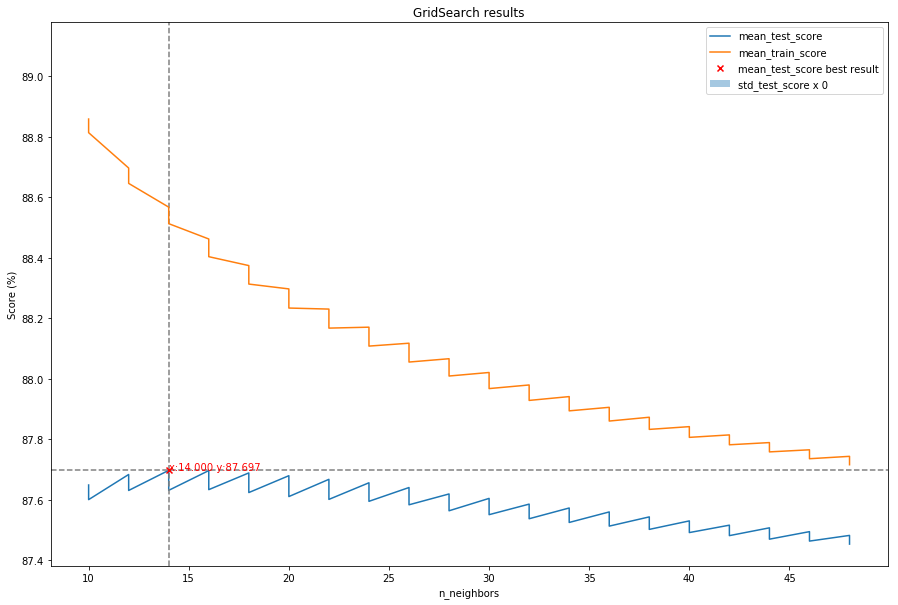

In [19]:
# Parameter name to plot
MODEL_PARAM='n_neighbors'

# Plot train and validation curve
results_df=grid_df.sort_values(f'param_model__{MODEL_PARAM}')

plot_grid_search_results(results_df, x_param=f'param_model__{MODEL_PARAM}', semilogx=False, xlabel=MODEL_PARAM, std_factor=0)

### Graphical representation with p=1 only

Results of the previous grid search indicates that p=1 is the best choice.

Here is the same graph as above filtered on values where *p* parameter equals 1.

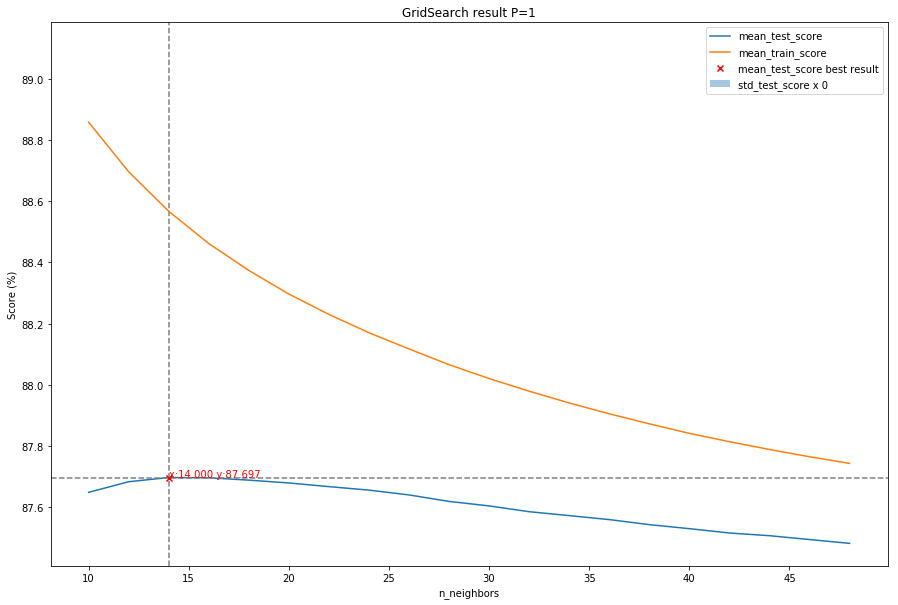

In [20]:
# Parameter name to plot
MODEL_PARAM='n_neighbors'

# Filter data point on p=P_VALUE
P_VALUE=1

# Plot train and validation curve
results_df=grid_df[grid_df['param_model__p'] == P_VALUE].sort_values(f'param_model__{MODEL_PARAM}')

plot_grid_search_results(results_df, x_param=f'param_model__{MODEL_PARAM}', semilogx=False, xlabel=MODEL_PARAM, std_factor=0,
                         title='GridSearch result P=1')

# Prediction

Ok, now that we've found the best parameters and get the best estimator via *GridSearchCV()*, let's calculate the *mean_absolute_error* in km/h and %

In [21]:
# Get best estimator from grid search and predict using X_va
y_pred=grid_search.predict(X_va)

# Get the MAE from y_pred
print("KNeighborsRegressor model mean absolute error         : {:.3f} km/h".format(mae(y_pred, y_va)))
print("KNeighborsRegressor model mean absolute percent error : {:.2f} %".format(mape(y_pred, y_va)))




KNeighborsRegressor model mean absolute error         : 1.354 km/h
KNeighborsRegressor model mean absolute percent error : 87.62 %


# Save model


In [22]:
save_model(grid_search, 'kneighbors')

Saving model kneighbors to ./data/model-kneighbors.sav using 'pickle' library


# What results could we expect if we reduce the size of training dataset ?

The previous grid search has been done with 10% of the original dataset and took a quite huge of computation time. The question now would be:

- What results do I get if I reduce dataset size to speed up computing time ?

Size of the training dataset have a direct effect on model prediction scores. To illustrate, I will redo a grid search using reduced size of the training dataset and compare results.

> Note: I will fix the *p* paramter to 1 and *n_neighbours* to (10,50) interval to limit computing time

## Train models with different training dataset size

Training dataset fraction that will be selected to train model are:

- 0.05%
- 0.1%
- 0.5%
- 1%
- 2%
- 5%

In [53]:
# Set specific model parameters to param_grid
param_grid["model__n_neighbors"]=[*range(10,50,2)]
param_grid["model__p"]=[1]
param_grid['scaler']=[StandardScaler()]
param_grid['pca']=[PCA(0.95)]

# Size of training dataset to test
size_to_train=[0.05, 0.1, 0.5, 1, 2, 5]

# All mape calulated will be store in this list
mape_y_pred=[]

for size in size_to_train:

    print("Training dataset fraction used: {}%".format(size))
    
    # Load X and y
    X_tr, y_tr, X_va, y_va=load_Xy(frac=size/100)
    print("Number of lines in training dataset:", X_tr.shape[0])

    # Initialize GridSearchCV object. Note that return_train_score=True
    reduced_grid_search = GridSearchCV(pipe,
                                       param_grid,
                                       scoring=custom_scorer,
                                       n_jobs=-1,
                                       cv=5,
                                       verbose=1,
                                       return_train_score=True,
                                       iid=True
                                      )

    # Do the grid search
    reduced_grid_search.fit(X_tr, y_tr)

    # Get best estimator from grid search and predict using X_va
    reduced_y_pred=reduced_grid_search.predict(X_va)
    
    # Evaluate preformance
    reduced_mape=mape(reduced_y_pred, y_va)
    
    # Add result to global variable
    mape_y_pred.append(reduced_mape)

    # Get the MAPE from reduced_y_pred
    print("KNeighborsRegressor MAPE : {:.2f} %\n".format(reduced_mape))
    


Training dataset fraction used: 0.05%
Number of lines in training dataset: 570
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


KNeighborsRegressor MAPE : 86.05 %

Training dataset fraction used: 0.1%
Number of lines in training dataset: 1140
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


KNeighborsRegressor MAPE : 85.86 %

Training dataset fraction used: 0.5%
Number of lines in training dataset: 5705
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished


KNeighborsRegressor MAPE : 86.32 %

Training dataset fraction used: 1%
Number of lines in training dataset: 11411
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


KNeighborsRegressor MAPE : 86.24 %

Training dataset fraction used: 2%
Number of lines in training dataset: 22822
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.0min finished


KNeighborsRegressor MAPE : 86.89 %

Training dataset fraction used: 5%
Number of lines in training dataset: 57056
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 61.9min finished


KNeighborsRegressor MAPE : 87.28 %



## Display performance results per training dataset size

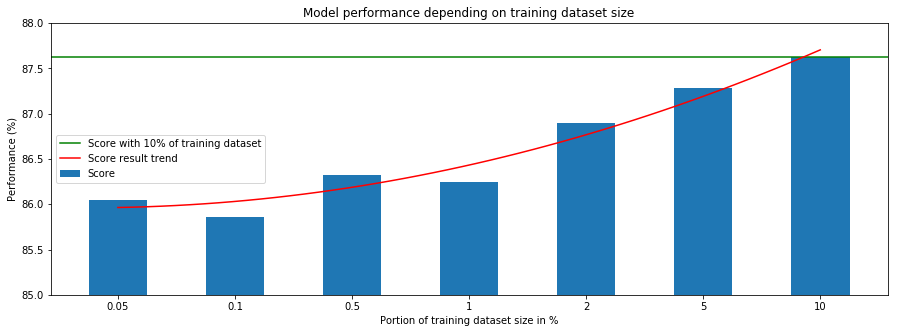

In [75]:

# Append the performance obtained previously with 10% of training dataset
y_results=mape_y_pred.copy()
y_results.append(87.62)

# Define xticks for bar plt
x_ticks=list(range(len(y_results)))

# Define x_labels
x_labels=size_to_train.copy()
x_labels.append(10)

# Define dataset to be plotted
df=pd.DataFrame({
    'size': x_ticks,
    'prediction': y_results
})

# Set figure size
plt.figure(figsize=(15,5))

# Plot bar graph using dataset values
plt.bar(df['size'], df['prediction'], width=0.5, label='Score')
    
# Draw line of the performance obtained previously with 10% of training dataset
plt.axhline(y=87.62, color='green', label='Score with 10% of training dataset')

# Draw a degree=2 poly reg. to show trend
poly = np.poly1d(np.polyfit(x_ticks, df['prediction'], 2))
plt.plot(np.linspace(x_ticks[0], x_ticks[-1]), poly(new_x), color='red', label='Score result trend')

# Set X & Y axis properties
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.xlabel("Portion of training dataset size in %")
plt.ylim(85, 88)
plt.ylabel("Performance (%)")

# Add legend
plt.legend()

# Set title
plt.title("Model performance depending on training dataset size")

# Display graph
plt.show()



Without doubt, the more data in the training set, the better the prediction score is.

On the other size, when the training dataset is very small, the results obtained vary a lot, small datasets might perform well compared to a bigger one (see 0.05% and 0.1% scores). This can be explained by the fact that reduced training dataset parts are built using random functions. With small portion of it, the probability to have representative train/test values decrease and lead to random results.

Anyway, small dataset even if they demonstrate some noises in prediction, are unable to beat biggest one. All of the previous score are beyond the one obtained with 10% of the *full* training dataset.


# Time to go to the next model

A distance based one, the [RandomForestRegressor](33.Category%20Based%20-%20RandomForestRegressor.ipynb)